In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    if os.name == 'posix':
        sys.path.append(module_path+"/models")
    else:
        sys.path.append(module_path+"\\models")

from models import build_model, compare_result

dataset_path = os.path.abspath(os.path.join('..'))

if os.name == 'posix':
    dataset_path = dataset_path + ("/data/merged_sessions_products_data")
else:
    dataset_path = dataset_path + ("\\data\\merged_sessions_products_data")

sessions = pd.read_csv(dataset_path, sep=' ')

## Usunięcie redundantnych atrybutów

Ze zbioru danych, używanego do uczenia modeli, usunięte zostały informacje o id użytkownika oraz id sesji.

In [ ]:
sessions = sessions.drop(['session_id', 'user_id'], axis=1)

## One-hot encoding dla danych zawierających labele, a nie wartości

Dla wartości liczbowych, reprezentujących wysokość udzielonej zniżki na produkt oraz reprezentujących dzień tygodnia w którym dokonywany jest zakup, zastosowane zostało kodowanie 1 z n. Wartości te bowiem reprezentują kategorie w których zamykać mogą się dwa powyższe atrybuty, które są oddzielne i dla których reprezentacja liczbowa mogłaby implikować niepoprawne relacje między nimi.

In [ ]:
sessions = pd.get_dummies(sessions, columns = ['offered_discount', 'weekday', 'month'])

## Podział zbioru na podzbiory: testowy i treningowy

Postanowiliśmy podzielić zbiór danych uzyskany z łączenia danych w proporcji: 12% danych testowych i 88% danych treningowych. Zdefiniowaliśmy również zależność wyboru danych treningowych i testowych od pewnego konkretnego ziarna losowego w tym konkretnym momencie.

In [ ]:
seed = 116
test_size = 0.12

X = sessions.drop('purchase', axis=1)
Y = sessions[['purchase']]
records_num = len(sessions)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print('Size of entire dataset: ', records_num)
print('Size of training set: ', len(X_train))
print('Size of test set: ', len(X_test))

Size of entire dataset:  37003
Size of training set:  32562
Size of test set:  4441


In [ ]:
X_train.head()

,price,duration,hour,unique_item_views,item_views,click_rate,last_session_purchase,offered_discount_0,offered_discount_5,offered_discount_10,...,month_April,month_August,month_February,month_January,month_July,month_June,month_March,month_May,month_October,month_September
23450,63.49,1324.0,4.0,8.0,8.0,0.362538,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23228,79.90,114.0,13.0,2.0,2.0,1.052632,False,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18251,207.33,0.0,5.0,1.0,1.0,0.000000,False,1,0,0,...,0,0,0,0,0,1,0,0,0,0
31403,99.99,115.0,8.0,2.0,3.0,1.565217,True,0,0,0,...,0,0,0,0,1,0,0,0,0,0
36388,14.99,47.0,23.0,2.0,2.0,2.553191,False,1,0,0,...,0,0,0,0,0,0,0,1,0,0


## Usunięcie powiązanych ze sobą atrybutów

Aby wyznaczyć istotnie ważne atrybuty które pozwolą na zbudowanie skutecznego modelu, wyliczyliśmy wartości korelacji między wszystkimi atrybutami metodą korelacji rangowej Spearmana. Wyniki obliczeń zostały przedstawione poniżej.

<AxesSubplot:>

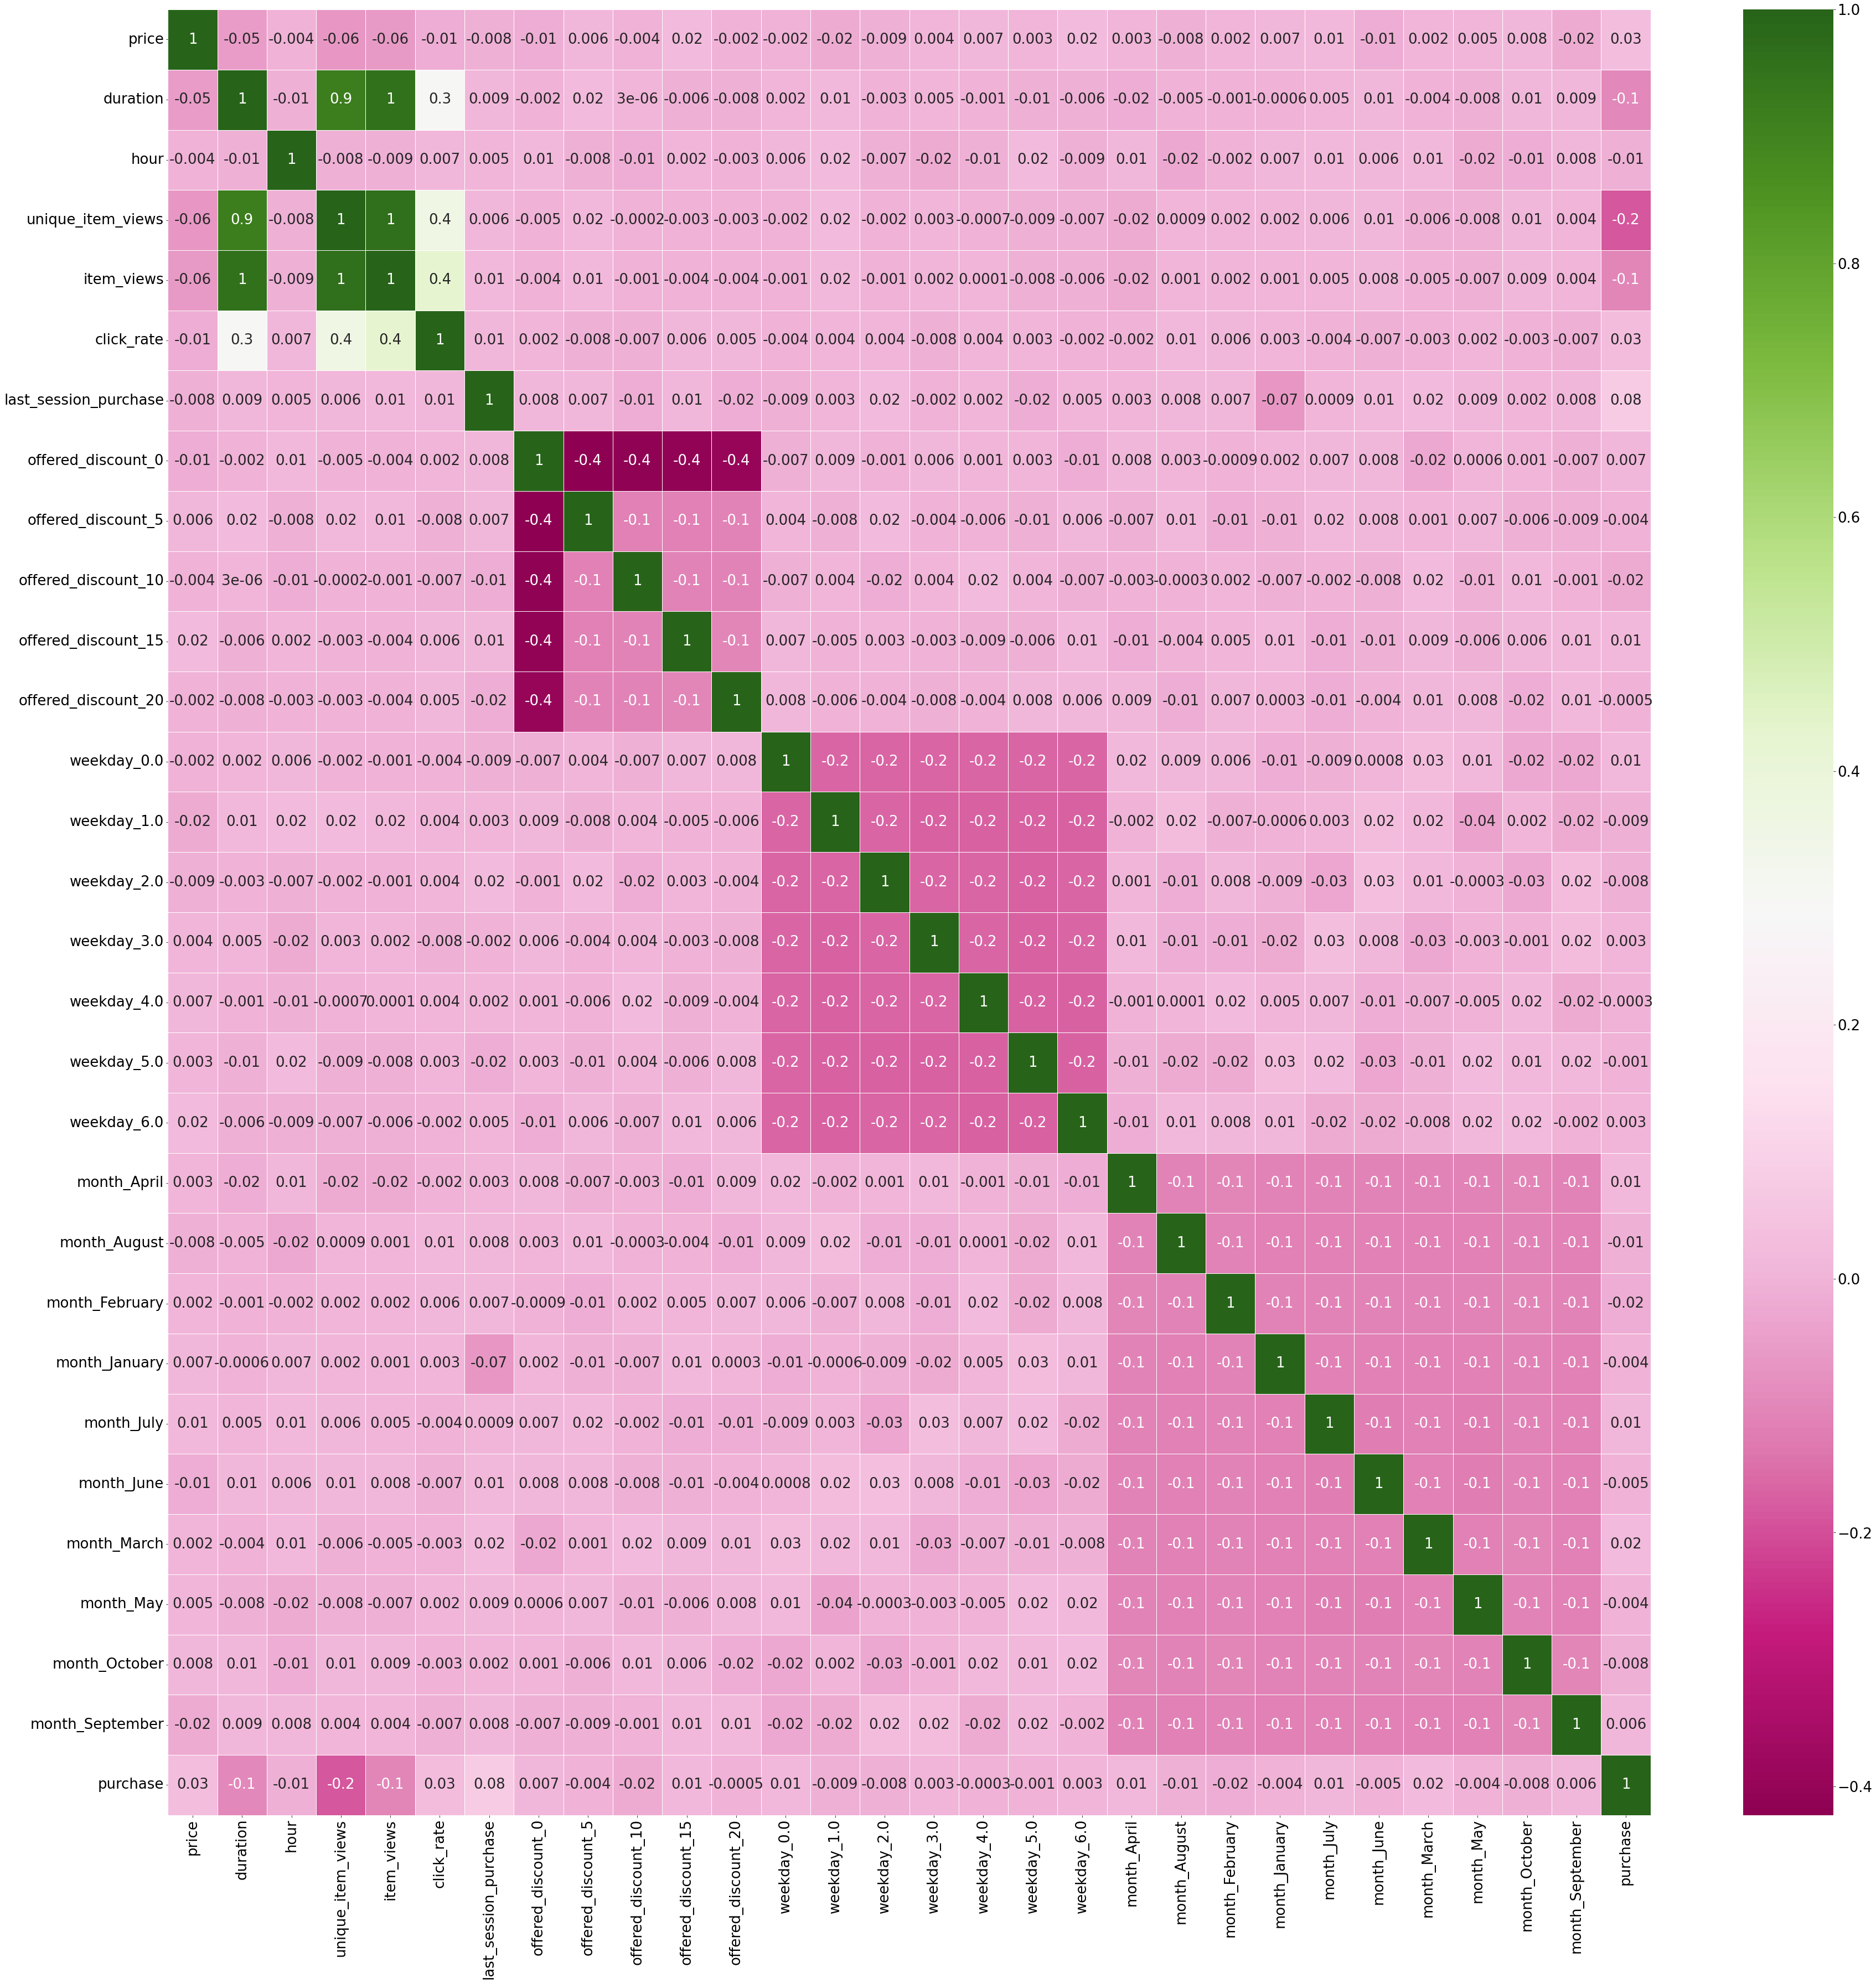

In [ ]:
plt.rcParams['figure.figsize'] = [60, 60]
plt.rcParams.update({'font.size': 26})

train = pd.concat([X_train, Y_train], axis=1)

sns.heatmap(
    train.corr(method = 'spearman'),
    xticklabels = train.columns,
    yticklabels = train.columns,
    annot=True,
    fmt='0.1g',
    linewidths=.5,
    cmap="PiYG"
)

Z wyliczeń wynika, że bardzo dużą korelację posiadają atrybuty: długości trwania sesji, liczby wyświetlonych przedmiotów oraz liczby wyświetlonych unikalnych przedmiotów. Wykonanie testu Chi² pozwoli na określenie, które z tych atrybutów nie będą wykorzystane jako wejście modelu.

## Wykonanie testu Chi² na wszystkich atrybutach

In [ ]:
def chi_sq(two_attributes_values_array, categories=[-1, -1]): 
    
    categories_array = []
    
    for i in range(2):
        if categories[i] <= -1:
            categories_array.append(np.sort
                                    (np.unique
                                     (two_attributes_values_array[:, i]))
                                        .tolist())
            
        else:
            categories_array.append(np.linspace(
                                    np.amin(two_attributes_values_array[:, i]),
                                    np.amax(two_attributes_values_array[:, i]), 
                                    categories[i])
                                    .tolist())
            
    freq_of_occurence_array = np.zeros((len(categories_array[0]), 
                                        len(categories_array[1])))
    
    for row_of_two_attr in two_attributes_values_array:
        index_first_col = sum(n <= row_of_two_attr[0] 
                              for n in categories_array[0])
        index_second_col = sum(n <= row_of_two_attr[1] 
                               for n in categories_array[1])
        freq_of_occurence_array[index_first_col-1][index_second_col-1] += 1

    n = np.sum(freq_of_occurence_array)
    n_i_array = np.sum(freq_of_occurence_array, axis=1)
    n_j_array = np.sum(freq_of_occurence_array, axis=0)
    chi = 0
    
    for i in range(freq_of_occurence_array.shape[0]):
        for j in range(freq_of_occurence_array.shape[1]):
            expected = (n_i_array[i]*n_j_array[j])/n
            
            if freq_of_occurence_array[i][j] == 0:
                continue
                
            chi += (freq_of_occurence_array[i][j]-expected)**2/expected
    return chi

In [ ]:
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X_train, Y_train)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X_train.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj = dfObj.sort_values(by=[0], ascending = False)

display(dfObj)

,0,1
1,128971.427333,duration
0,9223.848623,price
3,1466.241466,unique_item_views
4,529.580203,item_views
5,98.404989,click_rate
6,82.143777,last_session_purchase
2,15.452649,hour
25,11.488228,month_March
9,11.323649,offered_discount_10
21,7.573450,month_February


Stworzona na etapie dokumentacji wstępnej metoda chi² została zamieniona na bibliotecznę funkcję chi2, która wspiera szybkie wyliczanie wartości statystyki chi² dla wszystkich atrybutów w zbiorze danych. Spośród wyżej wspomnianych, skorelowanych atrybutów item_views, unique_item_views oraz duration usuwamy te atrybuty związane z ilością obejrzanych przedmiotów. Mają bowiem mniejszą wartość chi², oraz są ze sobą mocno skorelowane. Usunięte zostaną również z wejścia modelu te atrybuty, które mają bardzo niską wartość statystyki korelacji - to jest wartość mniejszą niż 2.

## Prezentacja ostatecznych wejść i wyjść konstruowanych modelów

VVVV - trzeba przeredagować

Zatem naszymi danymi wejściowymi modelu będą następujące atrybuty:

duration - długość trwania sesji w sekundach
click_rate - liczba zdarzeń(event'ów) do aktualnego rekordu na minutę
weekday_0.0 - weekday_6.0 - one hot encoding dni tygodnia
hour - godzina
offered_discount_10, 15, 20 - one hot encoding 10, 15 oraz 20%-owej zniżki
weekend - wartość boolowska odpowiadająca na pytanie czy sesja trwa w weekend
Ponadto dodaliśmy nowe atrybuty:

last_session_purchase - odpowiada na pytanie czy ostatnia sesja zakończyła się zakupem
price - cena przeglądanego produktu
Natomiast zmienną celu jest prawdopoboieństwo tego, że sesja zakończy się zakupem. Model będzie zwracał, że sesja zakończy się zakupem jeśli prawdopodobieństwo zakupu będzie większe od pewnej wartości granicznej.

In [ ]:
sessions = pd.read_csv("merged_dataset", sep=' ')

result_dict = {}
dropped_cols_with_corelated_attr = list(dfObj[dfObj[0] < 1][1])
dropped_cols_with_corelated_attr.extend(['session_id'])

dropped_cols_without_corelated_attr = dropped_cols_with_corelated_attr[:]
dropped_cols_without_corelated_attr.extend(['unique_item_views'])
onehot_cols = ['hour']

FileNotFoundError: [Errno 2] No such file or directory: 'merged_dataset'

## Model bazowy - regresja logistyczna

In [ ]:
def logistic_fn_tuning(X_train, Y_train):
    # hyperparameters tuning
    model = LogisticRegression(max_iter=500)
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['l2']
    space['C'] = [100, 10, 1.0, 0.1, 0.01]

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)
    search.fit(X_train, Y_train)
    
    print(search.best_estimator_) # model = LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
    return search.best_estimator_

def logistic_fn(X_train, Y_train):
    model = LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
    model.fit(X_train, Y_train)
    
    return model

result_dict['Logistic Regression with corelated attributes'] = \
    build_model(logistic_fn, sessions, onehot_cols, dropped_cols_with_corelated_attr, 'purchase', 
                seed, test_size)

result_dict['Logistic Regression without corelated attributes'] = \
    build_model(logistic_fn, sessions, onehot_cols, dropped_cols_without_corelated_attr, 'purchase', seed, test_size, output = './microservice/models/logistic_reg.pkl')

## Zaawansowany model docelowy - regresja logistyczna

In [ ]:
def random_forest_fn_tuning(X_train,Y_train):
    model = RandomForestClassifier()
    
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)
    
    # define search space
    space = dict()
    space['n_estimators'] = [100, 200, 250, 300, 350, 400, 500, 800, 1200]
    space['max_depth'] = [5, 8, 10, 15, 20, 25, 30]
    space['min_samples_split'] = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
    space['min_samples_leaf'] = [1, 2, 5, 10] 
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)
    search.fit(X_train, Y_train)
    
    print(search.best_estimator_) # RandomForestClassifier(max_depth=25, min_samples_split=15, n_estimators=300)
    
    return search.best_estimator_

def random_forest_fn(X_train,Y_train):
    model = RandomForestClassifier(max_depth=9, min_samples_split=15, n_estimators=300) 
    model.fit(X_train, Y_train)
    
    return model
    
result_dict['Random_Forest with corelated attributes'] = \
    build_model(random_forest_fn, sessions, onehot_cols, dropped_cols_with_corelated_attr,
                'purchase', seed)
result_dict['Random_Forest without corelated attributes'] = \
    build_model(random_forest_fn, sessions, onehot_cols, dropped_cols_without_corelated_attr, 'purchase', seed, output='./microservice/models/random_forest.pkl')

## Porównanie wyników prezentowanych przez modele

In [ ]:
scope = ['training', 'test']
records = []
for name in result_dict:
    for option in scope:
        record = []
        for key in result_dict[name][option]:
            record.append(result_dict[name][option][key])
        records.append(record)
            
df = pd.DataFrame.from_records(records)
df.columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
df.index = ['LR with corelated attributes / training data', 'LR with corelated attributes / test data', 
            'LR without corelated attributes / training data', 'LR without corelated attributes / test data', 
            'RF with corelated attributes / training data', 'RF with corelated attributes / test data', 
            'RF without corelated attributes / training data', 'RF without corelated attributes / test data']
df

## Analiza uzyskanych wyników

VVVV - przeredagować 


Zaproponowaliśmy 2 modele tj. model bazowy będący regresją logistyczną oraz bardziej zaawansowany model docelowy będący modelem lasów losowych. Dodatkowo dla każdego z modeli rozpatrzyliśmy 2 przypadki:

uwzględnienie skorelowanych atrybutów
usunięcie skorelowanych atrybutów tj. usunięcie atrybutów 'unique_item_views' oraz 'item_views' i zachowanie atrybutu 'duration'
Dla każdego z powyższych modeli obliczyliśmy miarę Accuracy oraz F1-score. Pierwsza wartość opisuje liczbę trafnych przewidywań do wszystkich próbek. Natomiast F1-score jest średnią harmoniczną z recall oraz precision.

Zdecydowaliśmy się jednak, że naszą analityczną miarą sukcesu będzie F1-score, ponieważ nasze zadanie biznesowe polega na "klasyfikacji sesji, które zakończą się zakupem co umożliwi konsultantom szybsze rozwiązywanie problemów". Z tego można wywnioskować, że zależy nam na tym aby:

liczba przypadków nieprawidłowo sklasyfikowanych jako sesje niekupujące była jak najmniejsza, dzięki czemu nie pomijamy sesji kupujących, które będą mogły wymagać interwencji konsultantów
liczba przypadków sklasyfikowanych niepoprawnie jako sesja kupująca była jak najmniejsza dzięki czemu oszczędzamy czas konsultantów
Z tego wynika, że bardziej zależy nam nam na False Negative'ach oraz False Positive'ach niż na True Positive'ach oraz True Negative'ach

Analizując wyniki, możemy zauważyć że model Random Forest ma większą miarę F1 od regresji logistycznej zarówno w przypadku zachowania skorelowanych atrybutów jak i w przypadku usnięcia ich.
W obu przypadkach postanowiliśmy usunąć atrybuty skorelowane tj. 'unique_item_views' oraz 'item_views' z racji na wartości F1.